In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score

df = pd.read_csv('c:/Users/Owen/books_small.csv')

In [2]:
print(df.shape)
df.head()

(1000000, 10)


,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,5111046,A38UEYF5AFDU4I,1416583475,"Jason Joyner ""On the journey""","[0, 0]","Overview: What would a Mexican housekeeper, a ...",5.0,Fiction with Themes that Matter,1272326400,"04 27, 2010"
1,8287159,A3RGUSBU339O2S,B00CPSGLEE,Amazon Customer,"[0, 0]",I began reading as soon as I downloaded and di...,4.0,Fast Paced!,1381968000,"10 17, 2013"
2,6903249,A194K60CWZ371J,1607746336,Ellybean,"[0, 0]",The Mix & Match Guide to Companion Planting is...,5.0,Useful for Any Level Gardener!,1403654400,"06 25, 2014"
3,5982295,ARMNRH4HV1W4B,148118928X,Miss g,"[2, 2]",It isn't often I have an opportunity to read a...,4.0,The Carpenter - Review,1364515200,"03 29, 2013"
4,1752754,A3IOBVF6E8SPRL,0373295987,Sue,"[0, 0]","I love this book. Very interesting story, char...",5.0,"Carla Kelly is great, and this is one of her b...",1391558400,"02 5, 2014"


In [12]:
# Get majority class baseline.
target = 'overall'
majority_class = df[target].mode()[0]
baseline_guess = [majority_class] * len(df)
print('Majority class baseline accuracy: ', accuracy_score(df[target], baseline_guess))

Majority class baseline accuracy:  0.5590185411124667


In [13]:
# Drop the 60 missing reviews. 
df = df.dropna(subset=['reviewText']) 

In [14]:
df.shape

(999940, 10)

In [15]:
import spacy
import string
from spacy.lang.en import English
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [16]:
# Create punctuation list.
punctuations = string.punctuation

# Create stopwords list.
# nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load tokenizer, tagger, parser, NER, and word vectors.
parser = English()

# Create tokenizer function.
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    
    # For each token, lemmatize and change to lowercase.
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != '-PRON-'
                else word.lower_ for word in mytokens]
    # Remove stop words.
    mytokens = [word for word in mytokens if word not in stop_words
                and word not in punctuations]
    # Return preprocessed list of tokens.
    return mytokens

In [17]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [18]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer) # Don't think I need this line..

In [19]:
from sklearn.model_selection import train_test_split

# Create features matrix and target vector.
X = df['reviewText']
y = df[target]

# Randomly split data into stratified train (80%) and test (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

In [176]:
%%time
from sklearn.linear_model import LogisticRegression

# Instantiate the classifier with mostly default hyperparameters.
classifier = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1,
                                random_state=42)

# Create pipeline to clean, get bag-of-words review vectors, then run logistic
# regression.
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# Fit the model on train.
pipe.fit(X_train,y_train)

Wall time: 16min 26s


Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x00000296CA4F5C08>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x00000297C6448708>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_

In [177]:
%%time
from sklearn import metrics

# Create predictions vector from test features.
y_pred = pipe.predict(X_test)

# Find model accuracy.
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, y_pred))

Logistic Regression Accuracy: 0.6331979918795128


In [ ]:
# Credit for most of the nlp with spacy and custom transformer to Avinash Navlani. 
# https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

In [11]:
# from spacy import en_vectors_web_lg

In [95]:
# %%time
# # Gradient Boosting Decision Tree Classifier
# from lightgbm import LGBMClassifier
# classifier = LGBMClassifier(objective='multiclass', num_class=5, 
#                             metric='multi_error', num_threads=6, 
#                             random_state=42)

# # Create pipeline using Bag of Words 
# pipe = Pipeline([("cleaner", predictors()),
#                  ('vectorizer', bow_vector),
#                  ('classifier', classifier)])

# # model generation
# pipe.fit(X_train,y_train)

In [91]:
df[target].value_counts(normalize=True)

5.0    0.559019
4.0    0.250450
3.0    0.107219
2.0    0.046716
1.0    0.036596
Name: overall, dtype: float64

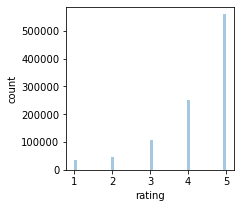

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
sns.distplot(df[target], kde=False)
plt.xlabel('rating')
plt.ylabel('count');

In [96]:
# To do:
# 1) Make multiple line graph of the number of each rating over the years.
# Like are people giving more 5s as time passes? See if the slope of each line
# is the same. Do I need to do time-based split?

# 2) In your model, set class_balance/class weights.

# 3) Figure out how leakage appllies to your data.

# 4) Figure out which accuracy metric to use.